# Hug and Hop

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from utils import logp as logp_scale
from Zappa.zappa import zappa_sampling_multivariate, zappa_sampling
from Zappa.ZappaStore import Zappa
from Manifolds.RotatedEllipse import RotatedEllipse
from utils import quick_MVN_scatter, MVN_scatters, prep_contour
from numpy.random import rand
from numpy.linalg import norm, solve, inv, det
from scipy.optimize import fsolve, root
from Manifolds.Manifold import Manifold
from tangential_hug_functions import Hug, HugTangential, NoAR
from utils import quick_3d_scatter, quick_3d_scatters, quick_MVN_marginals
import plotly.graph_objects as go

In [2]:
mu = np.zeros(2)
Sigma = np.array([[1.0, 0.99], [0.99, 2.0]])
target = multivariate_normal(mu, Sigma)
logpi = target.logpdf
grad_log_pi = lambda xy: - solve(Sigma, xy)
q = multivariate_normal(np.zeros(2), np.eye(2))
x0 = target.rvs()

In [3]:
T = 1.0
B = 5
n = 1
N = 10000
lam = 0.3 #1.5
k = 0.25

In [4]:
def Hop(x, lam, k, logpi, grad_log_pi):
    d = len(x)
    # Compute matrix square root
    mu_sq = k * lam
    mu = np.sqrt(mu_sq)
    lam_sq = lam**2
    # Compute normalized gradient at x
    gx = grad_log_pi(x)
    ngx = norm(gx)
    ghatx = gx / ngx
    # Sample from standard MVN
    u = multivariate_normal(np.zeros(d), np.eye(d)).rvs()
    # Transform to new sample
    y = (mu*u + (lam - mu) * ghatx * (ghatx @ u)) / max(1.0, ngx)
    # Compute stuff at y
    gy = grad_log_pi(y)
    ngy = norm(gy)
    # Acceptance probability
    logr = logpi(y) - logpi(x) 
    logr += d * (np.log(ngy) - np.log(ngx))
    logr -= (norm(y - x)**2) * (ngy**2 - ngx**2) / (2*mu_sq)
    logr -= 0.5 * (((y - x) @ gy)**2 - ((y - x) @ gx)**2)
    logr /= ((1 / lam_sq) - (1 / mu_sq))
    # Accept or reject
    if np.log(np.random.rand()) <= min(0, logr):
        # Accept
        return y, 1.0
    else:
        # Reject - stay where you are
        return x, 0.0

In [5]:
samples = x = x0
hug_acceptances = np.zeros(N)
hop_acceptances = np.zeros(N)
for _ in range(N):
    out_hug, acc_hug = Hug(x, T, B, 1, q, logpi, grad_log_pi)
    x_hug, hug_acceptances[_] = out_hug[-1], acc_hug
    x, acc_hop = Hop(x_hug, lam, k, logpi, grad_log_pi)
    hop_acceptances[_] = acc_hop
    samples = np.vstack((samples, x_hug, x))

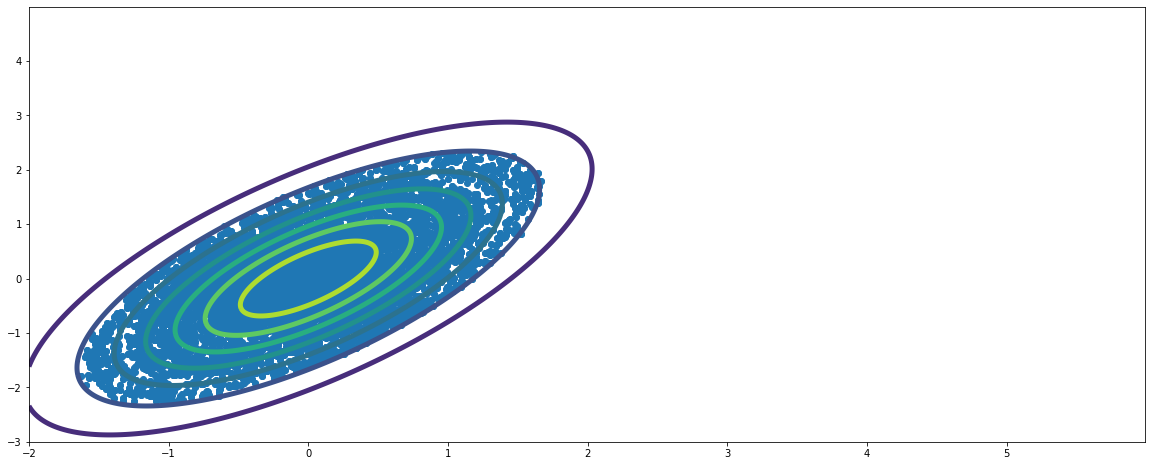

In [6]:
quick_MVN_scatter(samples,target)

In [7]:
print('Hug: {:.3}%'.format(100 * np.sum(hug_acceptances) / N))
print('Hop: {:.3}%'.format(100 * np.sum(hop_acceptances) / N))

Hug: 99.5%
Hop: 52.2%


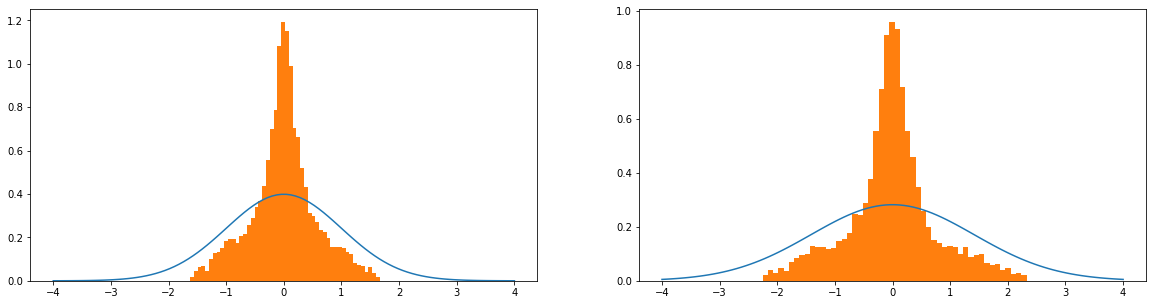

In [8]:
quick_MVN_marginals(samples, target)